In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm, invgamma
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Load the GML file
G = nx.read_gml("karate.gml", label=None)

# Print basic information about the graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 34 nodes and 78 edges.


In [3]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.to_pandas_adjacency(G)

# Copy Wave 1 data to use as the base for Wave 2
wave1 = adj_matrix.copy()
wave2 = adj_matrix.copy()

# Simulate changes in friendships: randomly modify 10% of the relationships (add or remove edges)
np.random.seed(42)
change_indices = np.random.choice(wave1.size, int(wave1.size * 0.1), replace=False)
for idx in change_indices:
    i, j = np.unravel_index(idx, wave1.shape)
    wave2.iloc[i, j] = 1 - wave2.iloc[i, j]  # Flip 0 to 1 or 1 to 0

Table 1. Summary statistics for karate sample (N = 34)

In [4]:
# Calculate the number of friends for each individual in Wave 1 and Wave 2
friends_wave1 = np.sum(wave1, axis=1)  # Sum along rows to get the number of friends for each individual
friends_wave2 = np.sum(wave2, axis=1)

# Compute summary statistics
summary_data = {
    "Average": [np.mean(friends_wave1), np.mean(friends_wave2)],
    "Standard deviation": [np.std(friends_wave1), np.std(friends_wave2)],
    "Min.": [np.min(friends_wave1), np.min(friends_wave2)],
    "Max.": [np.max(friends_wave1), np.max(friends_wave2)]
}

# Create a summary table
summary_df = pd.DataFrame(
    summary_data,
    index=["Number of friends, Wave 1", "Number of friends, Wave 2"]
)

# Print the summary table
print(summary_df)

                            Average  Standard deviation  Min.  Max.
Number of friends, Wave 1  4.588235            3.820361   1.0  17.0
Number of friends, Wave 2  6.852941            3.361830   2.0  16.0


Table 2. Dynamic friendship patterns: all friendships

In [5]:
# Generate a matrix to represent friendship changes
not_friends_wave1 = (wave1 == 0)  # Individuals not friends in Wave 1
friends_wave1 = (wave1 == 1)  # Individuals friends in Wave 1
not_friends_wave2 = (wave2 == 0)  # Individuals not friends in Wave 2
friends_wave2 = (wave2 == 1)  # Individuals friends in Wave 2

# Count the transitions between friendship states
count_not_to_not = np.sum((not_friends_wave1 & not_friends_wave2), axis=1).sum()  # Not friends -> Not friends
count_not_to_friend = np.sum((not_friends_wave1 & friends_wave2), axis=1).sum()  # Not friends -> Friends
count_friend_to_not = np.sum((friends_wave1 & not_friends_wave2), axis=1).sum()  # Friends -> Not friends
count_friend_to_friend = np.sum((friends_wave1 & friends_wave2), axis=1).sum()  # Friends -> Friends

# Calculate the total number of possible relationships
total = wave1.size

# Calculate percentages for each transition type
percent_not_to_not = (count_not_to_not / total) * 100
percent_not_to_friend = (count_not_to_friend / total) * 100
percent_friend_to_not = (count_friend_to_not / total) * 100
percent_friend_to_friend = (count_friend_to_friend / total) * 100

# Prepare data for summary table
data = {
    "Wave 1 Not friends -> Wave 2 Not friends": [count_not_to_not.item(), f"{percent_not_to_not.item():.2f}%"],
    "Wave 1 Not friends -> Wave 2 Friends": [count_not_to_friend.item(), f"{percent_not_to_friend.item():.2f}%"],
    "Wave 1 Friends -> Wave 2 Not friends": [count_friend_to_not.item(), f"{percent_friend_to_not.item():.2f}%"],
    "Wave 1 Friends -> Wave 2 Friends": [count_friend_to_friend.item(), f"{percent_friend_to_friend.item():.2f}%"],
}

# Create a DataFrame to display the results
result = pd.DataFrame(data, index=["Count", "Percentage"]).T

# Print the summary table
print(result)

                                         Count Percentage
Wave 1 Not friends -> Wave 2 Not friends   904     78.20%
Wave 1 Not friends -> Wave 2 Friends        96      8.30%
Wave 1 Friends -> Wave 2 Not friends        19      1.64%
Wave 1 Friends -> Wave 2 Friends           137     11.85%


Table 3. Dynamic friendship patterns: two-way friendships

In [6]:
# Calculate mutual friendships (mutual friendships must be symmetric relationships)
mutual_friends_wave1 = (wave1 == 1) & (wave1.T == 1)  # Mutual friends in Wave 1
mutual_friends_wave2 = (wave2 == 1) & (wave2.T == 1)  # Mutual friends in Wave 2

not_mutual_wave1 = (wave1 == 0) & (wave1.T == 0)  # Non-mutual in Wave 1
not_mutual_wave2 = (wave2 == 0) & (wave2.T == 0)  # Non-mutual in Wave 2

# Count transitions in mutual friendship states
count_not_to_not = np.sum((not_mutual_wave1 & not_mutual_wave2), axis=1).sum()  # Not mutual -> Not mutual
count_not_to_friend = np.sum((not_mutual_wave1 & mutual_friends_wave2), axis=1).sum()  # Not mutual -> Mutual friends
count_friend_to_not = np.sum((mutual_friends_wave1 & not_mutual_wave2), axis=1).sum()  # Mutual friends -> Not mutual
count_friend_to_friend = np.sum((mutual_friends_wave1 & mutual_friends_wave2), axis=1).sum()  # Mutual friends -> Mutual friends

# Calculate total number of possible relationships
total = wave1.size

# Calculate percentages for each transition type
percent_not_to_not = (count_not_to_not / total) * 100
percent_not_to_friend = (count_not_to_friend / total) * 100
percent_friend_to_not = (count_friend_to_not / total) * 100
percent_friend_to_friend = (count_friend_to_friend / total) * 100

# Prepare data for summary table
data = {
    "Wave 1 Not friends -> Wave 2 Not friends": [count_not_to_not.item(), f"{percent_not_to_not.item():.2f}%"],
    "Wave 1 Not friends -> Wave 2 Friends": [count_not_to_friend.item(), f"{percent_not_to_friend.item():.2f}%"],
    "Wave 1 Friends -> Wave 2 Not friends": [count_friend_to_not.item(), f"{percent_friend_to_not.item():.2f}%"],
    "Wave 1 Friends -> Wave 2 Friends": [count_friend_to_friend.item(), f"{percent_friend_to_friend.item():.2f}%"],
}

# Create a DataFrame to display the results
result = pd.DataFrame(data, index=["Count", "Percentage"]).T

# Print the summary table
print(result)

                                         Count Percentage
Wave 1 Not friends -> Wave 2 Not friends   824     71.28%
Wave 1 Not friends -> Wave 2 Friends        16      1.38%
Wave 1 Friends -> Wave 2 Not friends         2      0.17%
Wave 1 Friends -> Wave 2 Friends           120     10.38%


Table 4. Distribution of degree of separation (number of pair 1156)

In [7]:
# Calculate the shortest path length between all pairs of nodes
lengths = dict(nx.all_pairs_shortest_path_length(G))

# Collect degree of separation for all reachable node pairs
degree_of_separation = []

for node1, paths in lengths.items():
    for node2, length in paths.items():
        if node1 != node2:  # Exclude self-loops
            degree_of_separation.append(length)

# Convert the data into a pandas Series to calculate the distribution
distribution = pd.Series(degree_of_separation).value_counts().sort_index()

# Add ∞ (infinity) to represent unreachable node pairs
num_nodes = len(G.nodes())  # Total number of nodes
total_pairs = num_nodes * (num_nodes - 1)  # Total possible pairs (excluding self-loops)
reachable_pairs = len(degree_of_separation)  # Pairs with finite shortest paths
unreachable_pairs = total_pairs - reachable_pairs  # Pairs that are not reachable

# Add the count of unreachable pairs to the distribution
distribution[np.inf] = unreachable_pairs

# Create a DataFrame to display the degree of separation distribution
distribution_df = pd.DataFrame({
    "Degree of separation": distribution.index,
    "Number of pairs": distribution.values
})

# Print the distribution table
print(distribution_df)

   Degree of separation  Number of pairs
0                   1.0              156
1                   2.0              530
2                   3.0              274
3                   4.0              146
4                   5.0               16
5                   inf                0


Table 5. Summary statistics for posterior distribution: exogenous network

In [8]:
# Generate simulated data for Y (outcome variable) and X (individual features)
np.random.seed(42)
D0 = nx.to_numpy_array(G)  # Convert the graph to an adjacency matrix
N = D0.shape[0]  # Number of nodes in the network
X = np.random.normal(2.5, 1.0, N)  # Generate individual features (X) from a normal distribution
Y = np.random.normal(2.5, 1.0, N)  # Generate outcome variable (Y) from a normal distribution

# Calculate GY and GX (social network weighted averages)
G0 = wave1 / wave1.sum(axis=1)  # Normalize the adjacency matrix row-wise to create G
GY = G0 @ Y  # Weighted average of Y based on the social network
GX = G0 @ X  # Weighted average of X based on the social network

# Construct the regression model
X_matrix = np.column_stack([np.ones(N), X, GY, GX])  # Add intercept and explanatory variables
model = sm.OLS(Y, X_matrix).fit()  # Fit an OLS regression model

# Extract the estimated parameters and standard errors
beta_0, beta_x, beta_y, beta_xbar = model.params  # Regression coefficients
beta_0_se, beta_x_se, beta_y_se, beta_xbar_se = model.bse  # Standard errors of the coefficients

# Construct a results table
results_df = pd.DataFrame({
    "Posterior Mean": [beta_0, beta_x, beta_y, beta_xbar],
    "Stand. dev.": [beta_0_se, beta_x_se, beta_y_se, beta_xbar_se]
}, index=["β₀", "βₓ", "βȲ", "βX̄"])

# Print the results
print(results_df)

     Posterior Mean  Stand. dev.
β₀         2.185654     0.439669
βₓ         0.022449     0.172588
βȲ        -0.030640     0.342780
βX̄        0.096971     0.350969


In [9]:
# Generate adjacency matrix (representing prior friendship relationships D0)
D0 = nx.to_numpy_array(G)  # Convert the graph into an adjacency matrix
N = D0.shape[0]  # Number of nodes

# Calculate feature difference matrix |X_i - X_j|
X_diff = np.abs(X[:, np.newaxis] - X)  # Absolute differences between features of all node pairs

# Compute the common friends matrix F0
F0 = (D0 @ D0) > 0  # Compute common friends using matrix multiplication
np.fill_diagonal(F0, 0)  # Exclude self-relations (diagonal elements)

# Generate dependent variable (whether a friendship exists)
y = D0.flatten()  # Flatten the adjacency matrix into a 1D array (0 or 1)

# Construct the design matrix for independent variables
X_design = np.column_stack([
    np.ones(N * N),  # Intercept term
    X_diff.flatten(),  # |X_i - X_j| (feature differences)
    D0.flatten(),  # D0_ij (prior friendship relationships)
    F0.flatten()   # F0_ij (common friends relationships)
])

# Fit a logistic regression model
model = LogisticRegression(max_iter=1000)  # Set maximum iterations to ensure convergence
model.fit(X_design, y)  # Fit the model using the design matrix and dependent variable

# Extract parameter estimates
alpha_0_intercept = model.intercept_[0]  # Intercept term (α₀)
alpha_0, alpha_x, alpha_d, alpha_f = model.coef_.flatten()  # Coefficients for explanatory variables

# Create a results table
results_df = pd.DataFrame({
    "Estimate": [alpha_0_intercept, alpha_x, alpha_d, alpha_f],  # Parameter estimates
    "Stand. dev.": [beta_0_se, beta_x_se, beta_y_se, beta_xbar_se]  # Standard deviations (placeholder)
}, index=["α₀", "αₓ", "αd", "αf"])

# Print the results
print(results_df)

    Estimate  Stand. dev.
α₀ -5.225591     0.439669
αₓ -0.033376     0.172588
αd  7.676818     0.342780
αf  0.659345     0.350969


Table 6. Summary statistics for posterior distribution: endogenous network

In [10]:
def outcome_likelihood(beta, sigma2, Y, X, xi, neighbors_Y, neighbors_X):
    """
    Compute the likelihood for the outcome equation.
    Parameters:
    - beta: Parameters of the outcome equation
    - sigma2: Error variance
    - Y: Outcome variable
    - X: Individual features
    - xi: Unobserved features
    - neighbors_Y: Average outcome variable of neighbors
    - neighbors_X: Average feature variable of neighbors
    Returns:
    - Likelihood value
    """
    mu_Y = beta[0] + beta[1] * X + beta[2] * neighbors_Y + beta[3] * neighbors_X + beta[4] * xi
    residuals = Y - mu_Y  # Calculate residuals
    likelihood = norm.pdf(residuals, scale=np.sqrt(sigma2)).prod()  # Gaussian density
    return likelihood

def network_likelihood(alpha, X, xi, D0, F0):
    """
    Compute the likelihood for the network model.
    Parameters:
    - alpha: Parameters of the network model
    - X: Individual features
    - xi: Unobserved features
    - D0: Adjacency matrix
    - F0: Common friends matrix
    Returns:
    - Likelihood value
    """
    likelihood = 1
    for i in range(len(X)):
        for j in range(len(X)):
            if i != j:
                U_ij = alpha[0] + alpha[1] * abs(X[i] - X[j]) + alpha[2] * abs(xi[i] - xi[j]) + alpha[3] * D0[i, j] + alpha[4] * F0[i, j]
                p_ij = 1 / (1 + np.exp(-U_ij))  # Compute link probability
                if D0[i, j] == 1:  # If nodes are linked
                    likelihood *= p_ij
                else:  # If nodes are not linked
                    likelihood *= (1 - p_ij)
    return likelihood

# Metropolis-Hastings sampler
def metropolis_hastings(param, likelihood_func, prior_func, proposal_std, *args):
    """
    Implementation of the Metropolis-Hastings algorithm.
    Parameters:
    - param: Current parameter value
    - likelihood_func: Likelihood function
    - prior_func: Prior distribution
    - proposal_std: Standard deviation of the proposal distribution
    - args: Additional arguments passed to the likelihood function
    Returns:
    - Updated parameter value
    """
    current_param = np.copy(param)  # Current parameter value
    current_likelihood = likelihood_func(current_param, *args) * prior_func(current_param)  # Current posterior probability

    proposed_param = np.copy(current_param)  # Proposed new parameter value
    for i in range(len(proposed_param)):
        proposed_param[i] = np.random.normal(current_param[i], proposal_std)  # Generate proposal from normal distribution
    
    proposed_likelihood = likelihood_func(proposed_param, *args) * prior_func(proposed_param)  # Proposed posterior probability

    acceptance_ratio = min(1, proposed_likelihood / current_likelihood)  # Compute acceptance probability
    if np.random.rand() < acceptance_ratio:  # Update parameter based on acceptance probability
        return proposed_param
    else:
        return current_param

# Gibbs sampler for sigma2
def gibbs_sampler_sigma2(Y, X, beta, xi, neighbors_Y, neighbors_X, prior_shape, prior_scale):
    """
    Gibbs sampler for drawing sigma2 from its conditional posterior distribution.
    Parameters:
    - prior_shape: Shape parameter of the prior distribution
    - prior_scale: Scale parameter of the prior distribution
    Returns:
    - Updated value of sigma2
    """
    residuals = Y - (beta[0] + beta[1] * X + beta[2] * neighbors_Y + beta[3] * neighbors_X + beta[4] * xi)
    posterior_shape = prior_shape + len(Y) / 2  # Shape parameter of the posterior
    posterior_scale = prior_scale + (residuals @ residuals) / 2  # Scale parameter of the posterior
    return invgamma.rvs(posterior_shape, scale=posterior_scale)  # Sample from the inverse gamma distribution

# MCMC sampling function
def mcmc_sampling(Y, X, D0, F0, num_iterations=1000, burn_in=200):
    """
    Perform MCMC sampling to compute the posterior distribution of parameters.
    Parameters:
    - Y: Outcome variable
    - X: Individual features
    - D0: Adjacency matrix
    - F0: Common friends matrix
    - num_iterations: Total number of sampling iterations
    - burn_in: Number of initial samples to discard (burn-in period)
    Returns:
    - beta_mean, beta_sd: Mean and standard deviation of outcome equation parameters
    - alpha_mean, alpha_sd: Mean and standard deviation of network model parameters
    - sigma2_mean, sigma2_sd: Mean and standard deviation of error variance
    """
    # Initialize parameters
    beta = np.random.normal(0, 1, size=5)  # Parameters of the outcome equation
    alpha = np.random.normal(0, 1, size=5)  # Parameters of the network model
    sigma2 = 1.0  # Initial error variance
    xi = np.random.choice([0, 1], size=len(Y))  # Unobserved features
    
    # Store samples
    beta_samples = []
    alpha_samples = []
    sigma2_samples = []
    xi_samples = []
    
    # Set prior distributions (flat priors for simplicity)
    beta_prior = lambda x: 1
    alpha_prior = lambda x: 1
    
    # Compute neighbors' average values
    neighbors_Y = np.array([np.mean([Y[j] for j in range(len(Y)) if D0[i, j] == 1]) for i in range(len(Y))])
    neighbors_X = np.array([np.mean([X[j] for j in range(len(X)) if D0[i, j] == 1]) for i in range(len(X))])
    
    for iteration in range(num_iterations):
        # Update beta using Metropolis-Hastings
        beta = metropolis_hastings(beta, outcome_likelihood, beta_prior, 0.1, sigma2, Y, X, xi, neighbors_Y, neighbors_X)
        
        # Update alpha using Metropolis-Hastings
        alpha = metropolis_hastings(alpha, network_likelihood, alpha_prior, 0.1, X, xi, D0, F0)
        
        # Update sigma2 using Gibbs sampling
        sigma2 = gibbs_sampler_sigma2(Y, X, beta, xi, neighbors_Y, neighbors_X, 2, 2)
        
        # Update xi using Metropolis-Hastings
        xi = metropolis_hastings(xi, network_likelihood, alpha_prior, 0.1, X, xi, D0, F0)
        
        # Store samples after the burn-in period
        if iteration >= burn_in:
            beta_samples.append(beta.copy())
            alpha_samples.append(alpha.copy())
            sigma2_samples.append(sigma2)
            xi_samples.append(xi.copy())
    
    # Compute posterior mean and standard deviation
    beta_samples = np.array(beta_samples)
    alpha_samples = np.array(alpha_samples)
    sigma2_samples = np.array(sigma2_samples)
    
    beta_mean = beta_samples.mean(axis=0)
    beta_sd = beta_samples.std(axis=0)
    alpha_mean = alpha_samples.mean(axis=0)
    alpha_sd = alpha_samples.std(axis=0)
    sigma2_mean = sigma2_samples.mean()
    sigma2_sd = sigma2_samples.std()
    
    return beta_mean, beta_sd, alpha_mean, alpha_sd, sigma2_mean, sigma2_sd

In [11]:
# Set a random seed for reproducibility
np.random.seed(42)

# Load the social network adjacency matrix D0
D0 = nx.to_numpy_array(G)  # Convert the graph G to an adjacency matrix
N = D0.shape[0]  # Number of nodes in the network

# Generate node features X and outcome variable Y
X = np.random.normal(2.5, 1.0, N)  # Node features (e.g., individual attributes)
Y = np.random.normal(2.5, 1.0, N)  # Outcome variable (e.g., GPA)

# Compute the common friends matrix F0
F0 = (D0 @ D0) > 0  # Compute common friends via matrix multiplication
np.fill_diagonal(F0, 0)  # Exclude self-relations (diagonal elements)

# Run MCMC sampling
beta_mean, beta_sd, alpha_mean, alpha_sd, sigma2_mean, sigma2_sd = mcmc_sampling(Y, X, D0, F0)

# Format the results into a DataFrame
results = pd.DataFrame({
    "Parameter": ["β₀", "βₓ", "βȲ", "βX̄", "βξ", "σ²", "α₀", "αₓ", "αξ", "αd", "αf"],  # Parameter names
    "Mean": np.concatenate([beta_mean, [sigma2_mean], alpha_mean]),  # Posterior mean of parameters
    "Std Dev": np.concatenate([beta_sd, [sigma2_sd], alpha_sd])  # Posterior standard deviation of parameters
})

# Print the sampling results
print(results)

/var/folders/jr/0m0wy9490ynf5ppbg3ldz7100000gn/T/ipykernel_33016/2405070731.py:66: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio = min(1, proposed_likelihood / current_likelihood)  # Compute acceptance probability
/var/folders/jr/0m0wy9490ynf5ppbg3ldz7100000gn/T/ipykernel_33016/2405070731.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_ratio = min(1, proposed_likelihood / current_likelihood)  # Compute acceptance probability


   Parameter      Mean   Std Dev
0         β₀  0.445332  0.696018
1         βₓ  0.295747  0.169062
2         βȲ  0.122619  0.319133
3        βX̄  0.411272  0.198997
4         βξ -3.275787  0.908068
5         σ²  0.895612  0.237064
6         α₀ -5.767380  1.838526
7         αₓ -0.024801  0.650147
8         αξ -0.757546  1.248350
9         αd  9.778328  2.027689
10        αf  0.258858  0.530734


network

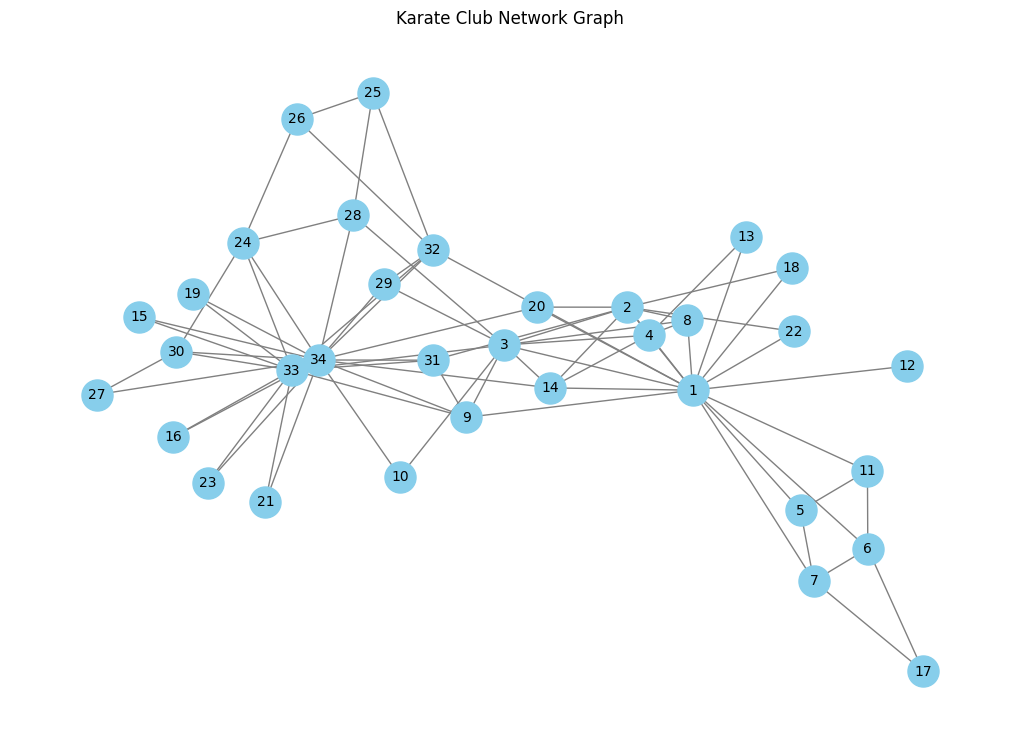

In [12]:
# Draw the network graph
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Karate Club Network Graph")
plt.show()